# 2. Normalization

In [19]:
import re
import string
import os
import shutil

import numpy as np
import pandas as pd

from polyleven import levenshtein

from gensim.models import FastText

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

To improve the reproducibility of the embeddings (but only partially), we provide seeds:

In [20]:
np.random.seed(76352)
%env PYTHONHASHSEED=76352

env: PYTHONHASHSEED=76352


## Data preprocessing

We define a minimalistic preprocessing regime:

In [26]:
hyphen = re.compile(r'\s*-\s*')
PUNCT = set(string.punctuation)

def preprocess(text):
    text = hyphen.sub(' ', text.lower())
    text = ' '.join(text.split())
    return ''.join([c for c in text if c not in PUNCT])

We load our data in a token tuple per era:

In [27]:
eras = []

for idx in range(1, 5):
    with open(f'../data/eras_raw/SP{idx}.txt') as f:
        text = f.read()
    eras.append(tuple(preprocess(text).split()))

In [28]:
eras[1][:20]

('field',
 'warranted',
 'found',
 'and',
 'very',
 'shey',
 'thettirs',
 'tor',
 'wrin',
 'the',
 'ohren',
 'to',
 'be',
 'sold',
 'by',
 'auction',
 'by',
 'mr',
 'bever',
 'vednefday')

FastText needs "sentences", but we don't have these and using the newlines in the data as an ad hoc delineator is very unreliable. We use random segments, with a fixed window size:

In [29]:
rnd_window_size = 100

windows = []
for era in eras:
    si, ei = 0, rnd_window_size
    while ei <= len(era):
        windows.append(era[si:ei])
        si += rnd_window_size
        ei += rnd_window_size

len(windows)

100762

We run a FastText model:

In [ ]:
min_count = 1
vector_size = 500
n_epochs = 20

ft = FastText(min_count=min_count, window=3, vector_size=vector_size,
              sentences=windows, epochs=n_epochs, seed=65973273)

## Evaluate normalization

We evaluate our spelling normalization system using a random sample of text, drawn in a balanced manner from all 4 time periods:

In [ ]:
spell_corr = pd.read_excel('../annotations/normalization.xlsx')
spell_corr = spell_corr[['token', 'correction']]
spell_corr.rename(columns = {'correction':'gold'}, inplace = True)
print(len(spell_corr))
spell_corr

In [ ]:
def normalize(token, ft_model, all_terms, threshold=.3):
    terms = {(levenshtein(token, t), t) for t in all_terms if ft.wv.distance(token, t) < threshold}
    if terms:
        return sorted(terms)[0][1]
    else:
        return None

In [30]:
all_terms = set(objects).union(set(modifiers))

silvers, golds = [], []

for token, gold in zip(spell_corr['token'], spell_corr['gold']):
    if gold in all_terms:
        golds.append(gold)
        silver = normalize(token, ft, all_terms, threshold=0.3)
        if silver:
            silvers.append(silver)
        else:
            silvers.append('NA')
    else:
        golds.append('NA')
        silvers.append('NA')

spell_corr['gold'] = golds
spell_corr['silver'] = silvers

spell_corr['gold'] = spell_corr['gold'].str.replace('s', 'f')
spell_corr['silver'] = spell_corr['silver'].str.replace('s', 'f')

In [32]:
spell_corr[spell_corr['gold'] != 'NA'].sample(60)

,token,gold,silver
958,chaife,chaife,chaife
3540,eight,eight,eight
1367,houfhold,houfehold,houfehold
2955,houre,houfe,houfe
3436,pipe,pipe,pipe
1366,genuine,genuine,genuine
187,red,red,red
2667,dining,dining,dining
2482,court,court,court
1440,largs,large,large


In [33]:
print('accuracy:', accuracy_score(spell_corr['gold'], spell_corr['silver']))
print('F1 score:', f1_score(spell_corr['gold'], spell_corr['silver'], average='macro'))
print('Precision:', precision_score(spell_corr['gold'], spell_corr['silver'], average='macro'))
print('Recall:', recall_score(spell_corr['gold'], spell_corr['silver'], average='macro'))

accuracy: 0.9802538787023978
F1 score: 0.8771629974637514
Precision: 0.907393607379509
Recall: 0.8621668098546711


/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's convert this to a Latex table for the paper:

In [42]:
res = pd.Series([accuracy_score(spell_corr['gold'], spell_corr['silver']),
                 f1_score(spell_corr['gold'], spell_corr['silver'], average='macro'),
                 precision_score(spell_corr['gold'], spell_corr['silver'], average='macro'),
                 recall_score(spell_corr['gold'], spell_corr['silver'], average='macro')])
res.index = ('accuracy', 'F1 (macro)', 'precision', 'recall')
print(res.to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
accuracy   &  0.980254 \\
F1 (macro) &  0.877163 \\
precision  &  0.907394 \\
recall     &  0.862167 \\
\bottomrule
\end{tabular}



/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Check:

In [34]:
spell_corr[spell_corr['gold'] != 'NA'].head(10)

,token,gold,silver
9,warehoufe,warehoufe,warehoufe
15,royal,royal,royal
36,large,large,large
39,rich,rich,rich
42,silver,filver,filver
45,fine,fine,fine
46,hollands,hollandf,hollandf
51,hofe,hofe,NA
53,uundry,fundry,fundry
63,exceeding,exceeding,exceeding


In [60]:
ex_correct = spell_corr[(spell_corr['gold'] != 'NA') & (spell_corr['gold'] == spell_corr['silver']) \
                        & (spell_corr['gold'] != spell_corr['token'])]
ex_correct.sample(10)

,token,gold,silver
1697,prefs,preff,preff
3461,indis,india,india
2045,premisesno,premifef,premifef
2464,cellering,cellaring,cellaring
277,silver,filver,filver
535,sconces,fconcef,fconcef
965,harnefs,harneff,harneff
312,curious,curiouf,curiouf
3503,botles,bottlef,bottlef
2806,aubatantial,fubftantial,fubftantial


Let's convert this to a Latex table for the paper:

In [64]:
print(ex_correct.sample(10).to_latex(index=False))

\begin{tabular}{lll}
\toprule
         token &          gold &        silver \\
\midrule
      houfhold &     houfehold &     houfehold \\
         defks &          defk &          defk \\
      rtanding &      ftanding &      ftanding \\
        botles &       bottlef &       bottlef \\
 handkerchiefs &  handkerchief &  handkerchief \\
        serges &        fergef &        fergef \\
      houfhold &     houfehold &     houfehold \\
   fachionable &   fafhionable &   fafhionable \\
       aluable &      valuable &      valuable \\
        mualin &        muflin &        muflin \\
\bottomrule
\end{tabular}



And the same for incorrect replacements:

In [66]:
ex_incorrect = spell_corr[(spell_corr['gold'] != 'NA') & (spell_corr['gold'] != spell_corr['silver']) \
                        & (spell_corr['gold'] != spell_corr['token'])]
print(ex_incorrect.sample(10).to_latex(index=False))
ex_incorrect.sample(10)

\begin{tabular}{lll}
\toprule
     token &       gold & silver \\
\midrule
    finale &     fingle &     NA \\
  pramttes &   premifef &     NA \\
    idengs &  refidence &     NA \\
     irigh &      irifh &     NA \\
      righ &       rich &     NA \\
  dameatle &   domeftic &     NA \\
 atxiroxar &  ftaircafe &     NA \\
     houfe &  houfehold &     NA \\
  aparinus &   fpaciouf &     NA \\
  darillay &   dwelling &     NA \\
\bottomrule
\end{tabular}



,token,gold,silver
3283,anefal,ufeful,NA
2683,co,court,NA
2531,orse,horfe,NA
3204,elemast,elegant,NA
3005,alaret,clofet,NA
3021,garvantal,fervantf,NA
3230,afaat,breakfaft,NA
3051,atabir,ftable,NA
1970,irigh,irifh,NA
2868,teatdengsin,refidence,NA


## Apply normalizer

We turn the data for each era into a dataframe for each separate era, and add a normalized column:

In [67]:
def normalize_eras(eras, ft, all_terms, threshold=.3):
    all_tokens = set()
    for era in eras:
        all_tokens.update(era)
    
    normalize_lookup = {}
    for token in tqdm(sorted(all_tokens)):
        silver = normalize(token, ft, all_terms, threshold=.3)
        if silver:
            normalize_lookup[token] = silver
        else:
            normalize_lookup[token] = token
    
    normalized_eras = []
    for era in eras:
        normalized = [normalize_lookup[token] for token in era]
        normalized_eras.append(pd.DataFrame(zip(era, normalized), columns=('token', 'normalized')))
    
    return normalized_eras

What is the original vocabulary richness?

In [72]:
from collections import Counter
token_counts = Counter()
for era in eras:
    token_counts.update(era)
print('total # types:', len(token_counts))
print('total # token:', np.sum(list(token_counts.values())))
print('richness:', np.sum(list(token_counts.values())) / len(token_counts))

total # types: 661117
total # token: 10076512
richness: 15.241647091210783


In [73]:
normalized_eras = normalize_eras(eras, ft, all_terms, threshold=.3)

100%|██████████| 661117/661117 [3:19:16<00:00, 55.29it/s]       


Verify whether we replaced anything at all:

In [74]:
test_era = normalized_eras[1]
test_era[test_era['token'] != test_era['normalized']].sample(20)

,token,normalized
2268719,mahogony,mahogany
2283579,chambers,chamber
1746471,yard,farm-yard
735851,greatly,great
1520595,yard,farm-yard
1771255,gardens,garden
2029035,room,bed-room
1390860,warehoufe,warehouse
1888191,stages,stage
2002647,manfion,mansion


How large has been the expected shift in vocabulary richness?

In [75]:
norm_token_counts = Counter()
for norm_era in normalized_eras:
    norm_token_counts.update(norm_era['normalized'])
print('total # types:', len(norm_token_counts))
print('total # token:', np.sum(list(norm_token_counts.values())))
print('richness:', np.sum(list(norm_token_counts.values())) / len(norm_token_counts))

total # types: 521516
total # token: 10076512
richness: 19.32157786146542


We persist the normalized eras to disk:

In [81]:
outdir = '../data/normalized'
try:
    shutil.rmtree(outdir)
except FileNotFoundError:
    pass
os.mkdir(outdir)

for idx, era in enumerate(normalized_eras):
    era.to_csv(f'{outdir}/SP{idx+1}.csv')

## Type-level embedding model

We rerun a FastText model on the normalized tokens. For this, we need to re-extract the random windows:

In [215]:
normalized_windows = []
for era in normalized_eras:
    norm_tokens = tuple(era['normalized'])
    si, ei = 0, rnd_window_size
    while ei <= len(norm_tokens):
        normalized_windows.append(norm_tokens[si:ei])
        si += rnd_window_size
        ei += rnd_window_size
len(normalized_windows)

100762

In [216]:
ft_norm = FastText(min_count=min_count, vector_size=vector_size,
                   window=5, # larger window for semantics
                   sentences=normalized_windows, epochs=n_epochs, seed=65973273)

In [217]:
def scatterplot(X, y, categories=None):
    X_tsne = TSNE(n_components=2, random_state=2000).fit_transform(X)
    if isinstance(categories, int):
        kmeans = KMeans(n_clusters=categories, random_state=0).fit(X_tsne)
        categories = kmeans.labels_
    else:
        categories = LabelEncoder().fit_transform(categories) + 2
    fig, ax = plt.subplots(figsize=(15, 15))
    c1, c2 = X_tsne[:, 0], X_tsne[:, 1]
    ax.scatter(c1, c2, facecolors='none')
    for p1, p2, l, c in zip(c1, c2, y, categories):
        ax.text(p1, p2, l, color=cmap(c / 10.),
                fontsize=11, font='arial', ha='center', va='center');
    plt.tight_layout()
    return categories

In [218]:
mod_headwords = list(mod_df['headword'])
mod_categories = list(mod_df['DEF'])

In [219]:
Counter(mod_categories).most_common()

[('D', 182), ('E', 100)]

Coloring based on position in plot:

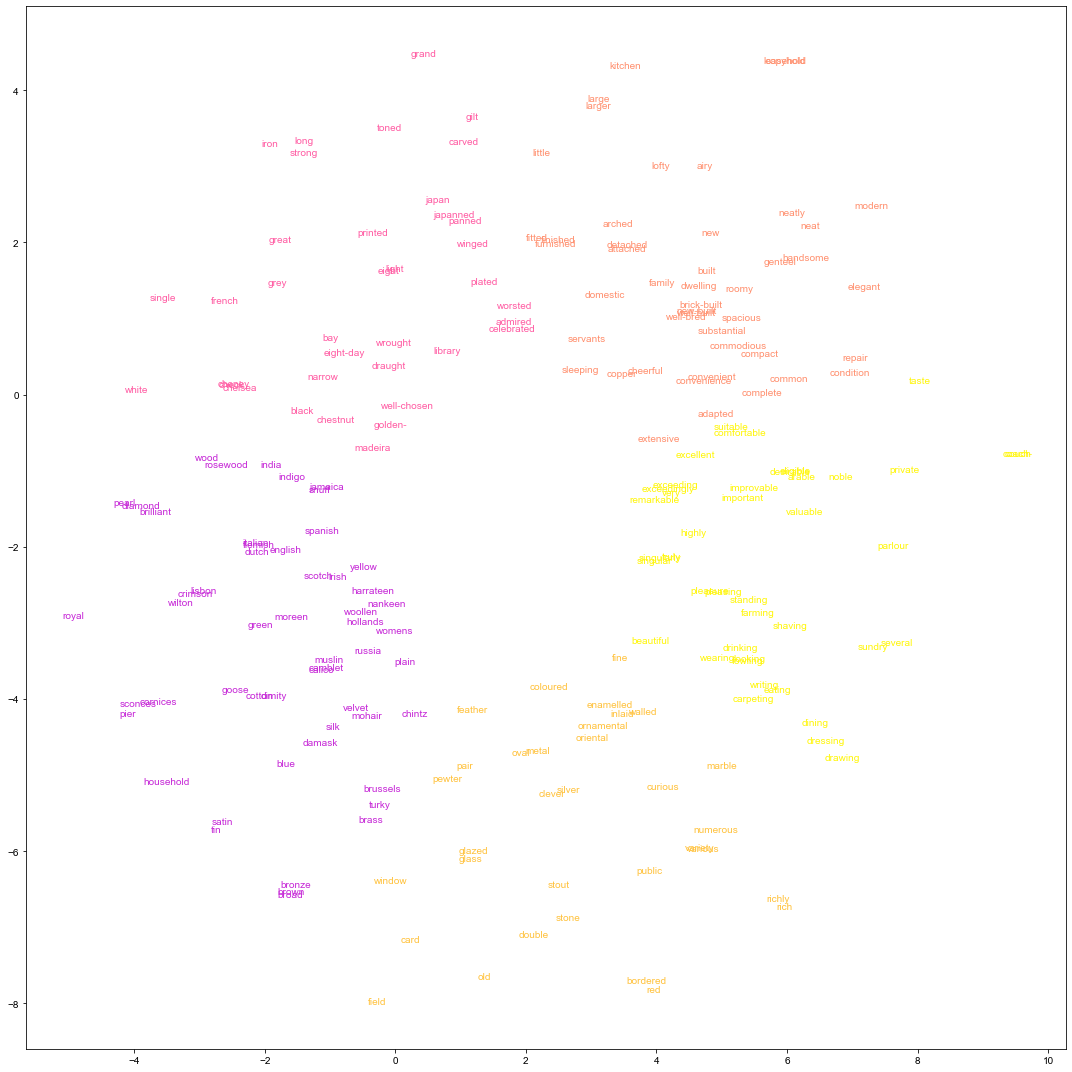

In [220]:
modifier_clusters = scatterplot(ft_norm.wv[mod_headwords], mod_headwords, categories=6)

Coloring based on E/D:

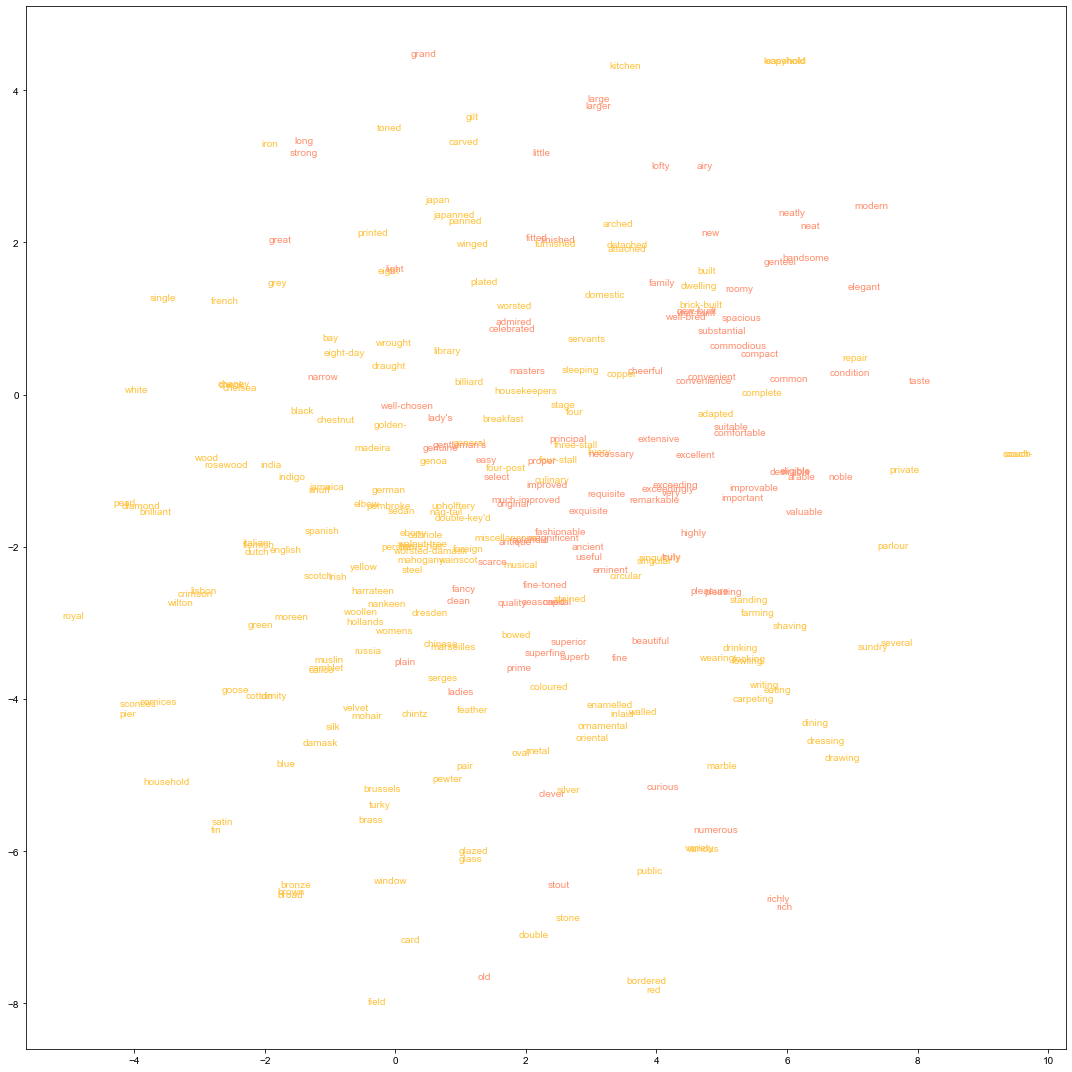

In [221]:
modifier_clusters = scatterplot(ft_norm.wv[mod_headwords], mod_headwords, categories=mod_categories)

In [222]:
kmeans = KMeans(n_clusters=len(set(mod_categories)), random_state=0).fit(ft_norm.wv[mod_headwords])
adjusted_rand_score(mod_categories, kmeans.labels_)

0.1178622643602543

Objects:

In [223]:
obj_headwords = list(obj_df['headword'])
obj_categories = list(obj_df['DEF'])

In [224]:
Counter(obj_categories).most_common()

[('real estate', 46),
 ('furniture', 25),
 ('decoration', 18),
 ('clothing/fabric', 10),
 ('appliances/utensils', 9),
 ('tableware', 6),
 ('accessories', 5),
 ('animal/accessories', 4),
 ('instrument', 4)]

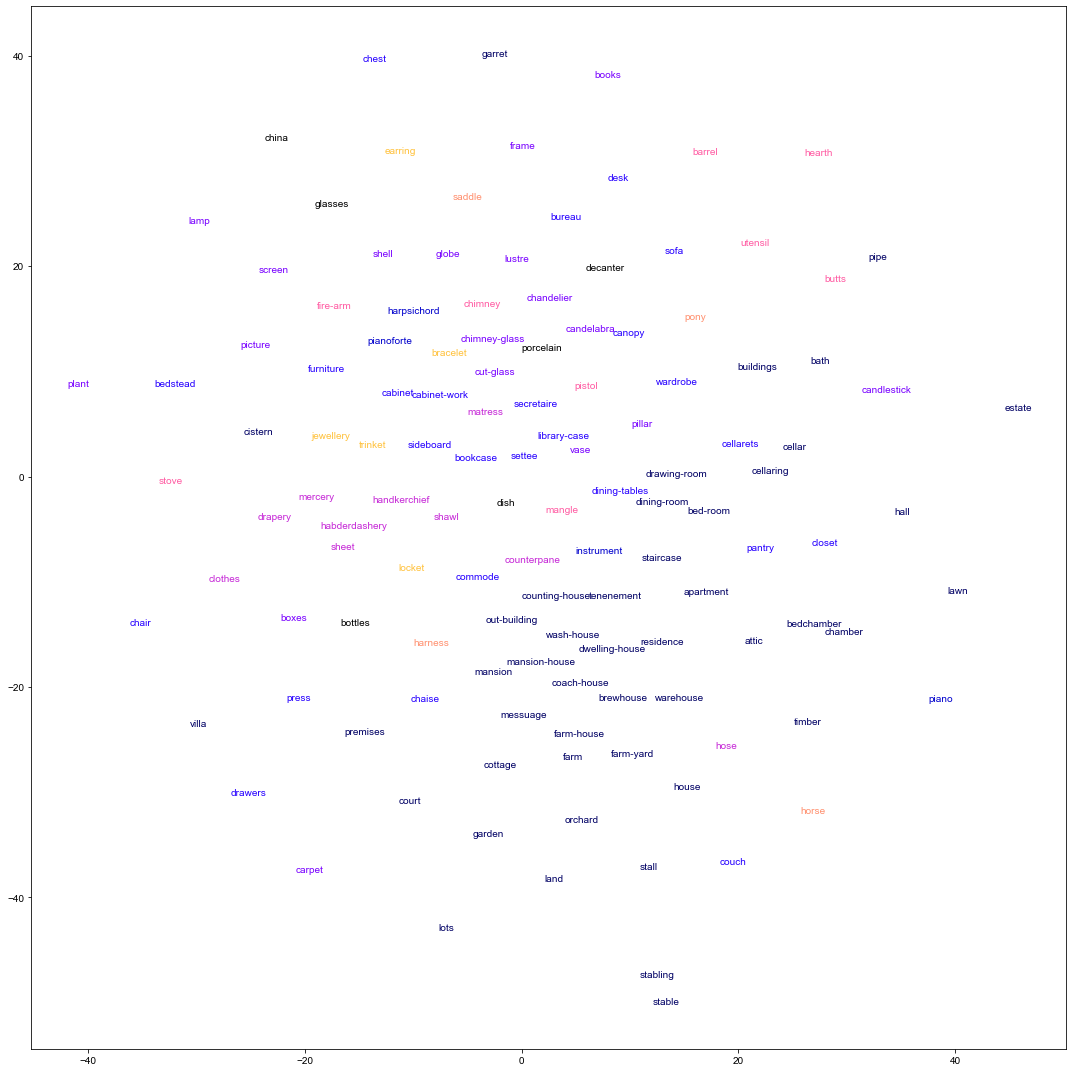

In [225]:
object_clusters = scatterplot(ft_norm.wv[objects], objects, categories=obj_categories)

In [226]:
kmeans = KMeans(n_clusters=len(set(obj_categories)), random_state=0).fit(ft_norm.wv[obj_headwords])
adjusted_rand_score(obj_categories, kmeans.labels_)

0.08375628009656946